In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [16]:
df = pd.read_csv('data/stackoverflow-pytorch.csv')

In [17]:
df.head(10)

,question_body,answer_body,answer_score
0,"<p>While ""googl'ing"" and doing some research I...","<p><strong>Edit 1</strong> See <a href=""https:...",39.0
1,"<p>I have a huge list of numpy arrays, where e...",<p>I think what DataLoader actually requires i...,159.0
2,<p>\nIs there a Pytorch-internal procedure to ...,<p>You can always leverage the fact that <code...,80.0
3,"<p>Following up the question from <a href=""htt...",<h1>List of differences between hand-rolled co...,12.0
4,<p>I get this error while trying to build a mu...,<p>Try adding <code>drop_last=True</code> in y...,12.0
5,<p>I have some question about pytorch's backwa...,<p>Please read carefully the documentation on ...,43.0
6,<p>My code looks like:</p>\n\n<pre><code>if no...,"<p>OP here: By writing down the question, I un...",9.0
7,<p>I am new to pytorch and are trying to imple...,<p>I think you're confused!</p>\n\n<p>Ignore t...,9.0
8,<p>I am quite unsure whether this is correct. ...,<p>The two examples you provided are exactly t...,19.0
9,<p>I am using <code>nn.DataParallel()</code> f...,<p>I changed this: <code>self.model = DataPara...,-2.0


In [18]:
df.shape

(24287, 3)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24287 entries, 0 to 24286
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   question_body  24287 non-null  object 
 1   answer_body    17343 non-null  object 
 2   answer_score   17343 non-null  float64
dtypes: float64(1), object(2)
memory usage: 569.4+ KB


In [20]:
df.describe()

,answer_score
count,17343.000000
mean,2.647869
std,11.571693
min,-7.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,663.000000


In [22]:
def strip_html(t: str) -> str:
    return re.sub(r"<[^>]+>", " ", t or "")

def normalize_text(t: str) -> str:
    t = strip_html(t).lower()
    t = re.sub(r"`{1,3}.*?`{1,3}", " ", t, flags=re.DOTALL)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def code_lengths(t: str) -> int:
    total = 0
    for m in re.finditer(r"```(.*?)```", t or "", flags=re.DOTALL):
        total += len(m.group(1))
    for m in re.finditer(r"<code>(.*?)</code>", t or "", flags=re.DOTALL|re.IGNORECASE):
        total += len(m.group(1))
    return total

def ngrams(tokens, n=1):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

STOP_EN = {"the","a","an","and","or","if","else","to","for","in","on","of","is","are","was","were","be","been","being","this","that","it","as","by","with","from","at","not","can","should","would","could","i","you","we","they","he","she","my","your","our","their","me","us","them","do","does","did","done","have","has","had","so","but","than","then","when","what","which","who","whom","how","why","where","there","here","also","use","using","used"}

In [23]:
df["question_body"] = df["question_body"].astype(str)
df["answer_body"]   = df["answer_body"].astype(str)
df["answer_score"]  = pd.to_numeric(df["answer_score"], errors="coerce")

q_raw = df["question_body"].fillna("")
a_raw = df["answer_body"].fillna("")
q = q_raw.map(normalize_text)
a = a_raw.map(normalize_text)

df["q_len_tokens"] = q.str.split().map(len)
df["a_len_tokens"] = a.str.split().map(len)
df["has_code"] = q_raw.str.contains(r"```|<code>|</code>", regex=True, na=False) | a_raw.str.contains(r"```|<code>|</code>", regex=True, na=False)
df["code_len_chars"] = q_raw.map(code_lengths) + a_raw.map(code_lengths)

overview = pd.DataFrame({
    "rows":[len(df)],
    "cols":[df.shape[1]],
    "memory_mb":[round(df.memory_usage(deep=True).sum()/(1024**2),2)],
    "duplicate_questions":[df["question_body"].duplicated().sum()]
})
nulls = df.isna().sum().to_frame("nulls").assign(share=lambda x: (x["nulls"]/len(df)).round(4))
dtypes = df.dtypes.to_frame("dtype")

display(overview)
display(nulls.sort_values("nulls", ascending=False))
display(dtypes)
display(df.sample(10, random_state=42)[["question_body","answer_body","answer_score"]])

,rows,cols,memory_mb,duplicate_questions
0,24285,7,86.95,0


,nulls,share
answer_score,6943,0.2859
question_body,0,0.0000
answer_body,0,0.0000
q_len_tokens,0,0.0000
a_len_tokens,0,0.0000
has_code,0,0.0000
code_len_chars,0,0.0000


,dtype
question_body,object
answer_body,object
answer_score,float64
q_len_tokens,int64
a_len_tokens,int64
has_code,bool
code_len_chars,int64


,question_body,answer_body,answer_score
23727,<p>I am trying to download MNIST data in PyTor...,"<p>This is a new bug, reported here: <a href=""...",6.0
9040,"<p>I use <a href=""https://nlp.johnsnowlabs.com...","<p>Not sure if this helps, but this refers to ...",0.0
11938,<p>I have been trying to figure this out for s...,"<p>If you are interested to find out, just tak...",0.0
5115,<p>I'm currently working on a project and part...,nan,NaN
7175,<p>I've been trying to follow a code which use...,nan,NaN
11785,"<p>A simple code from pytorch tutorial, which ...",<p>It's checking to see if the superclass's <c...,0.0
6530,<p>I've tried to run torch_TensorRT on ubuntu ...,nan,NaN
4420,<p>I've been getting the following error when ...,nan,NaN
8749,<p>I have devloped a blackberry app which pops...,<p>I am wondering about the method you are usi...,0.0
8859,"<p><a href=""https://i.stack.imgur.com/ArYcI.pn...",<p>The way data loaders work in PyTorch is qui...,0.0


In [24]:
def quantiles(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return pd.Series({
        "count": int(s.size),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "q05": s.quantile(0.05),
        "q25": s.quantile(0.25),
        "median": s.median(),
        "q75": s.quantile(0.75),
        "q95": s.quantile(0.95),
        "max": s.max(),
        "skew": s.skew(),
        "kurt": s.kurt()
    })

quant_table = pd.concat({
    "q_len_tokens": quantiles(df["q_len_tokens"]),
    "a_len_tokens": quantiles(df["a_len_tokens"]),
    "answer_score": quantiles(df["answer_score"])
}, axis=1)

def iqr_table(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    out = ((s < low) | (s > high)).mean()
    return pd.Series({"q1": q1,"q3": q3,"iqr": iqr,"low": low,"high": high,"outlier_share": round(float(out),4)})

iqr_df = pd.concat({
    "answer_score": iqr_table(df["answer_score"]),
    "a_len_tokens": iqr_table(df["a_len_tokens"]),
    "q_len_tokens": iqr_table(df["q_len_tokens"])
}, axis=1)

corr_spearman = df[["answer_score","q_len_tokens","a_len_tokens"]].corr(method="spearman")

display(quant_table.round(3))
display(iqr_df.round(3))
display(corr_spearman.round(3))

,q_len_tokens,a_len_tokens,answer_score
count,24285.000,24285.000,17342.000
mean,229.414,79.333,2.648
std,252.109,120.060,11.572
min,4.000,1.000,-7.000
q05,41.000,1.000,0.000
q25,90.000,1.000,0.000
median,155.000,46.000,1.000
q75,275.000,105.000,2.000
q95,647.000,275.000,9.000
max,5716.000,2819.000,663.000


,answer_score,a_len_tokens,q_len_tokens
q1,0.000,1.000,90.000
q3,2.000,105.000,275.000
iqr,2.000,104.000,185.000
low,-3.000,-155.000,-187.500
high,5.000,261.000,552.500
outlier_share,0.086,0.056,0.071


,answer_score,q_len_tokens,a_len_tokens
answer_score,1.000,-0.083,0.183
q_len_tokens,-0.083,1.000,-0.028
a_len_tokens,0.183,-0.028,1.000


In [25]:
from collections import Counter

API_PATTERNS = {
    "torch.nn": r"\btorch\.nn\.([A-Za-z_][A-Za-z0-9_]*)",
    "torch.optim": r"\btorch\.optim\.([A-Za-z_][A-Za-z0-9_]*)",
    "torchvision": r"\btorchvision\.([A-Za-z_][A-Za-z0-9_]*)",
    "utils.data": r"\btorch\.utils\.data\.([A-Za-z_][A-Za-z0-9_]*)",
    "torch.cuda": r"\btorch\.cuda\.([A-Za-z_][A-Za-z0-9_]*)",
    "torch.jit": r"\btorch\.jit\.([A-Za-z_][A-Za-z0-9_]*)",
    "torch.compile": r"\btorch\.compile\b",
    "autocast": r"\bautocast\b",
    "no_grad": r"\bno_grad\b",
    "GradScaler": r"\bGradScaler\b",
    "DataLoader": r"\bDataLoader\b",
    "Dataset": r"\bDataset\b"
}

api_counts = Counter()
full_text_iter = (q_raw.str.cat(a_raw, sep=" \n ").str.lower()).tolist()
for text in full_text_iter:
    for key, pat in API_PATTERNS.items():
        matches = re.findall(pat, text)
        if isinstance(matches, list):
            for m in matches:
                if isinstance(m, tuple):
                    m = m[0]
                token = f"{key}.{m}" if m and key not in {"torch.compile","autocast","no_grad","GradScaler","DataLoader","Dataset"} else key
                api_counts[token] += 1

top_api = pd.DataFrame(api_counts.most_common(30), columns=["api","count"])

def tokenize_for_counts(series: pd.Series):
    tokens_all = []
    for text in series:
        t = re.sub(r"[0-9_]", " ", text)
        t = re.sub(r"[^a-zA-Z]+", " ", t)
        toks = [w for w in t.lower().split() if w not in STOP_EN and len(w) > 2]
        tokens_all.extend(toks)
    return tokens_all

q_tokens = tokenize_for_counts(q)
a_tokens = tokenize_for_counts(a)

unigrams_q = pd.DataFrame(Counter(q_tokens).most_common(30), columns=["term","count"])
unigrams_a = pd.DataFrame(Counter(a_tokens).most_common(30), columns=["term","count"])
bigrams_q = pd.DataFrame(Counter(ngrams(q_tokens, 2)).most_common(30), columns=["bigram","count"])
bigrams_a = pd.DataFrame(Counter(ngrams(a_tokens, 2)).most_common(30), columns=["bigram","count"])

display(top_api)
display(unigrams_q)
display(unigrams_a)
display(bigrams_q)
display(bigrams_a)

,api,count
0,no_grad,1947
1,torch.nn.functional,1815
2,utils.data.dataloader,1714
3,torch.cuda.is_available,1705
4,torchvision.transforms,1112
5,torch.nn.linear,1110
6,torch.optim.adam,1063
7,torch.nn.module,1047
8,torchvision.datasets,790
9,torchvision.models,682


,term,count
0,self,115061
1,quot,113000
2,torch,89346
3,model,63032
4,size,53458
5,loss,46853
6,data,43912
7,train,41427
8,input,32738
9,import,32391


,term,count
0,torch,27003
1,quot,17729
2,self,17291
3,model,13696
4,tensor,13363
5,size,12895
6,data,9799
7,pytorch,8202
8,input,7926
9,batch,7343


,bigram,count
0,quot quot,23411
1,batch size,13571
2,site packages,13167
3,lib python,12837
4,file quot,11249
5,quot line,10824
6,init self,10231
7,python site,8921
8,import torch,7937
9,packages torch,7812


,bigram,count
0,nan nan,7074
1,quot quot,4906
2,batch size,3078
3,torch tensor,2975
4,import torch,2310
5,init self,1923
6,kernel size,1640
7,requires grad,1348
8,def init,1315
9,state dict,1105


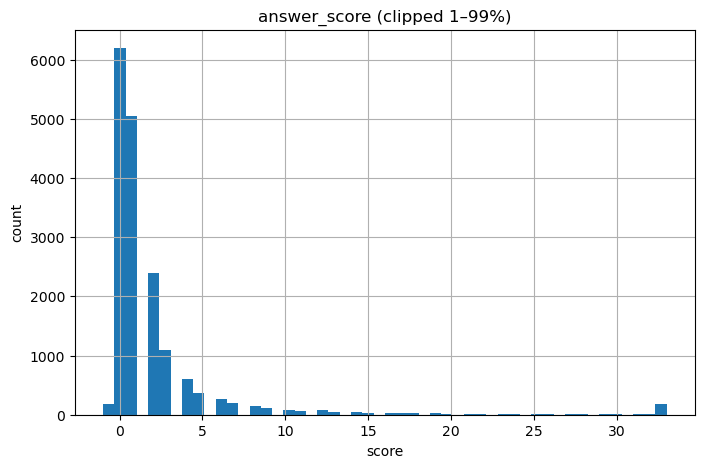

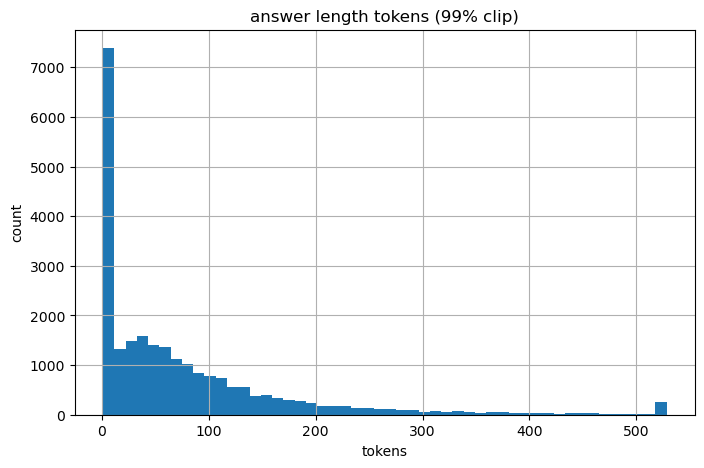

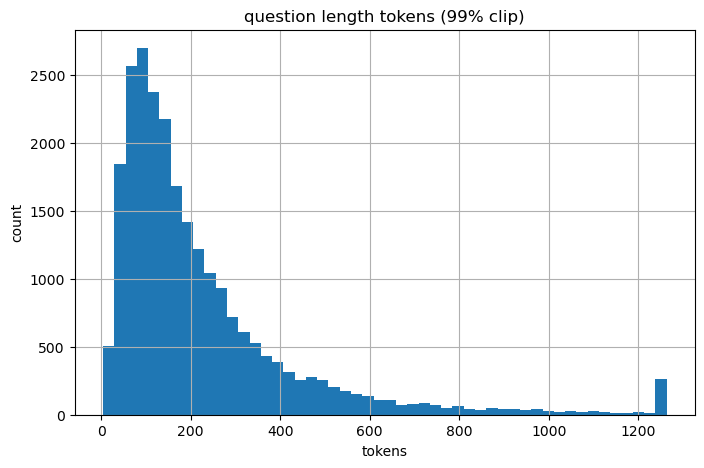

<Figure size 700x500 with 0 Axes>

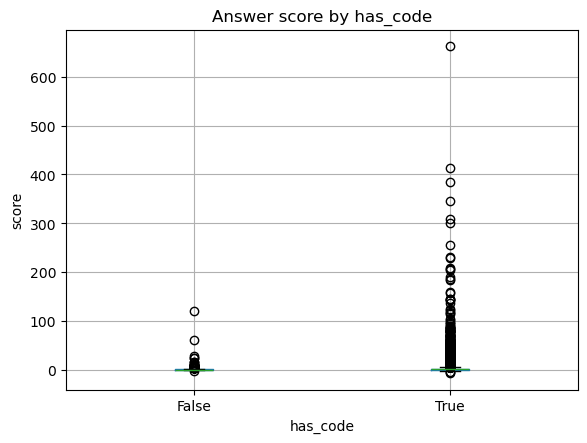

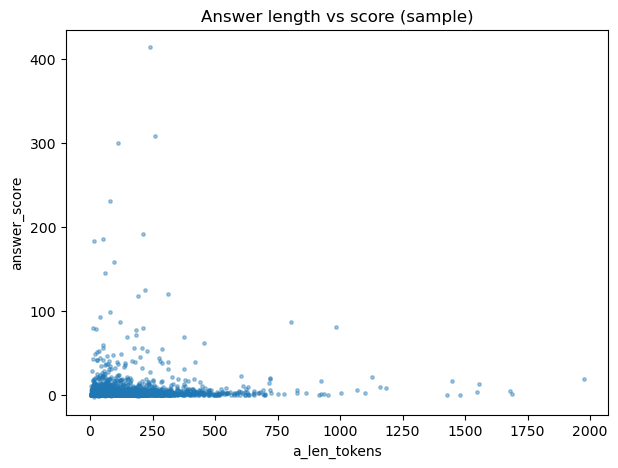

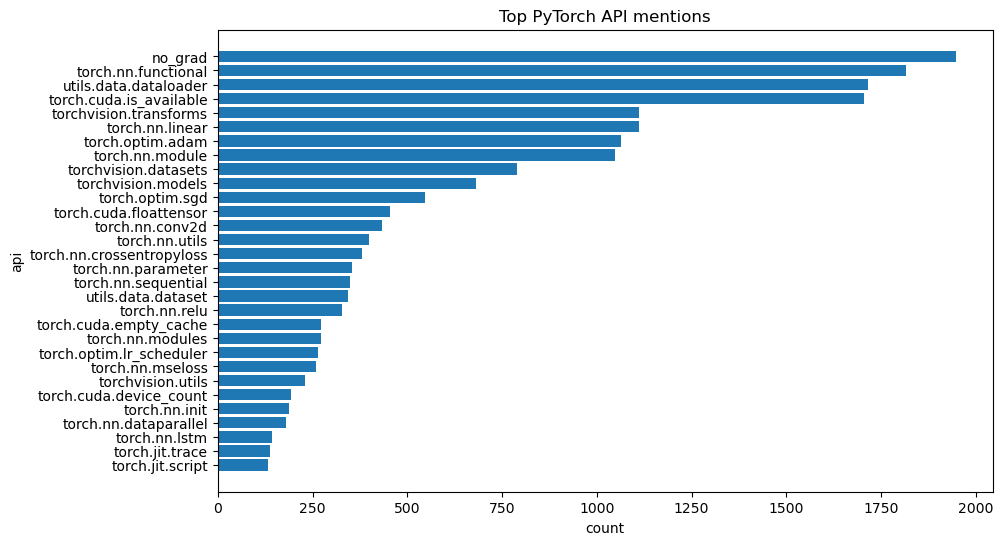

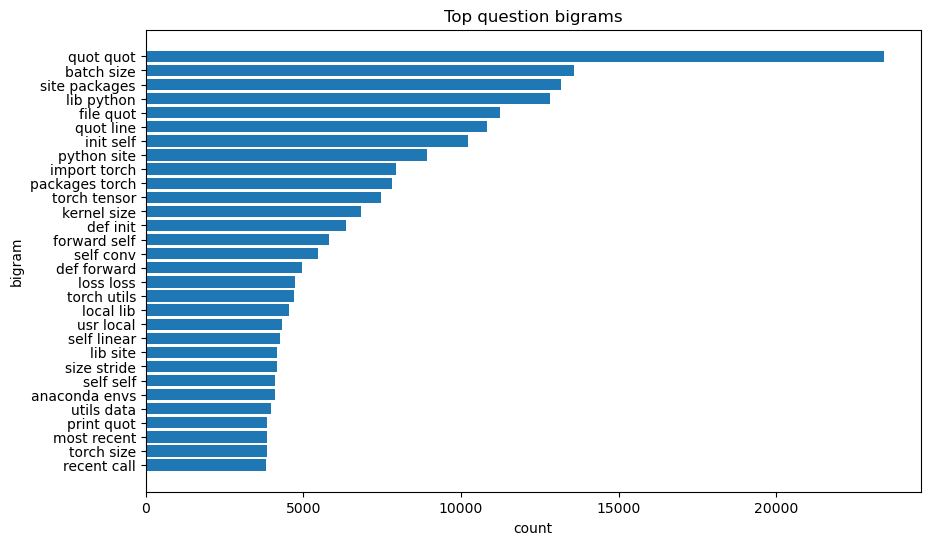

In [26]:
plt.figure(figsize=(8,5))
df["answer_score"].dropna().clip(df["answer_score"].quantile(0.01), df["answer_score"].quantile(0.99)).hist(bins=50)
plt.title("answer_score (clipped 1–99%)"); plt.xlabel("score"); plt.ylabel("count"); plt.show()

plt.figure(figsize=(8,5))
df["a_len_tokens"].clip(upper=df["a_len_tokens"].quantile(0.99)).hist(bins=50)
plt.title("answer length tokens (99% clip)"); plt.xlabel("tokens"); plt.ylabel("count"); plt.show()

plt.figure(figsize=(8,5))
df["q_len_tokens"].clip(upper=df["q_len_tokens"].quantile(0.99)).hist(bins=50)
plt.title("question length tokens (99% clip)"); plt.xlabel("tokens"); plt.ylabel("count"); plt.show()

plt.figure(figsize=(7,5))
df.boxplot(column="answer_score", by="has_code")
plt.title("Answer score by has_code"); plt.suptitle(""); plt.xlabel("has_code"); plt.ylabel("score"); plt.show()

sample = df[["a_len_tokens","answer_score"]].dropna()
if len(sample) > 5000:
    sample = sample.sample(5000, random_state=42)
plt.figure(figsize=(7,5))
plt.scatter(sample["a_len_tokens"], sample["answer_score"], s=6, alpha=0.4)
plt.title("Answer length vs score (sample)"); plt.xlabel("a_len_tokens"); plt.ylabel("answer_score"); plt.show()

plt.figure(figsize=(10,6))
plt.barh(top_api["api"].iloc[::-1], top_api["count"].iloc[::-1])
plt.title("Top PyTorch API mentions"); plt.xlabel("count"); plt.ylabel("api"); plt.show()

plt.figure(figsize=(10,6))
plt.barh(bigrams_q["bigram"].iloc[::-1], bigrams_q["count"].iloc[::-1])
plt.title("Top question bigrams"); plt.xlabel("count"); plt.ylabel("bigram"); plt.show()